# Kafka and Spark Streaming in Colab
> Installing Kafka and Spark streaming in colab and streaming movielens dataset

- toc: true
- badges: true
- comments: true
- categories: [spark, pyspark, kafka, movie]
- image:

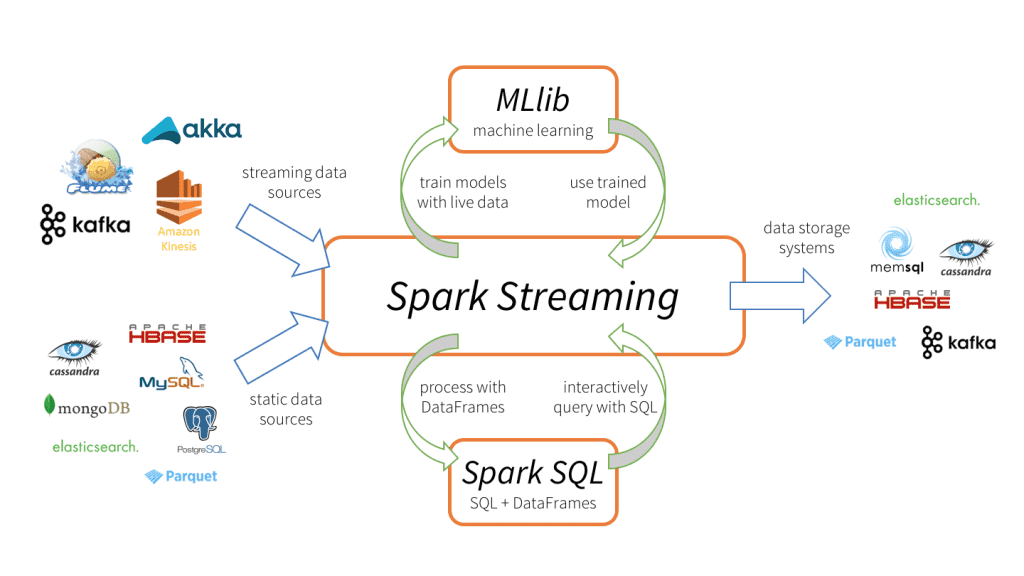

There are several benefits of implementing Spark-Kafka integration. You can ensure minimum data loss through Spark Streaming while saving all the received Kafka data synchronously for an easy recovery. Users can read messages from a single topic or multiple Kafka topics. 

Along with this level of flexibility you can also access high scalability, throughput and fault-tolerance and a range of other benefits by using Spark and Kafka in tandem. This integration can be understood with a data pipeline that functions in the methodology shown below:

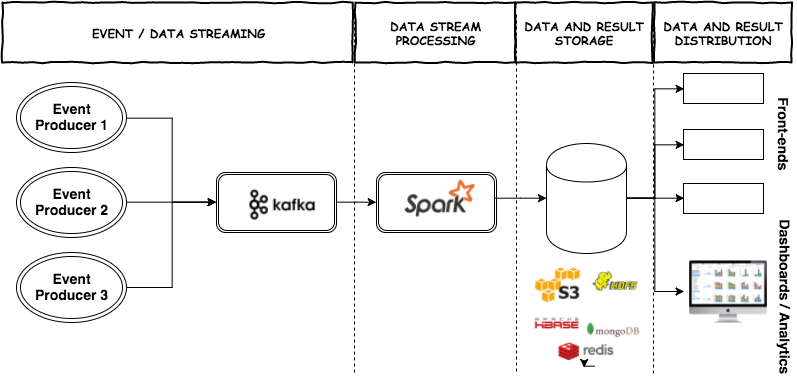

In [8]:
!pip install kafka-python

     |████████████████████████████████| 256kB 7.0MB/s 


### Import packages

In [9]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
import pandas as pd
from sklearn.model_selection import train_test_split

## Download and setup Kafka and Zookeeper instances

For demo purposes, the following instances are setup locally:

- Kafka (Brokers: 127.0.0.1:9092)
- Zookeeper (Node: 127.0.0.1:2181)


In [10]:
!curl -sSOL https://downloads.apache.org/kafka/2.7.0/kafka_2.13-2.7.0.tgz
!tar -xzf kafka_2.13-2.7.0.tgz

Using the default configurations (provided by Apache Kafka) for spinning up the instances.

In [11]:
!./kafka_2.13-2.7.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-2.7.0/config/zookeeper.properties
!./kafka_2.13-2.7.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-2.7.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Once the instances are started as daemon processes, grep for `kafka` in the processes list. The two java processes correspond to zookeeper and the kafka instances.

In [12]:
!ps -ef | grep kafka

root         406     359  5 04:12 ?        00:00:16 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /content/spark-3.1.2-bin-hadoop3.2/conf/:/content/spark-3.1.2-bin-hadoop3.2/jars/* -Xmx1g org.apache.spark.deploy.SparkSubmit --conf spark.jars.packages=org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5 pyspark-shell
root         901       1 11 04:17 ?        00:00:01 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xloggc:/content/kafka_2.13-2.7.0/bin/../logs/zookeeper-gc.log -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:+PrintGCTimeStamps -XX:+UseGCLogFileRotation -XX:NumberOfGCLogFiles=10 -XX:GCLogFileSize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.7.0/bin/../logs -Dlog4j.configur

Create the kafka topics with the following specs:

- susy-train: partitions=1, replication-factor=1 
- susy-test: partitions=2, replication-factor=1 

In [13]:
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic reco-train
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic reco-test


Created topic reco-train.
Created topic reco-test.


Describe the topic for details on the configuration

In [14]:
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic reco-train
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic reco-test

Topic: reco-train	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: reco-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: reco-test	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: reco-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: reco-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


The replication factor 1 indicates that the data is not being replicated. This is due to the presence of a single broker in our kafka setup.
In production systems, the number of bootstrap servers can be in the range of 100's of nodes. That is where the fault-tolerance using replication comes into picture.

Please refer to the [docs](https://kafka.apache.org/documentation/#replication) for more details.


## Movielens Dataset

Kafka being an event streaming platform, enables  data from various sources to be written into it. For instance:

- Web traffic logs
- Astronomical measurements
- IoT sensor data
- Product reviews and many more.

For the purpose of this tutorial, lets download the [Movielens](https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_100K_ratings.csv?raw=true) dataset and feed the data into kafka manually.


In [15]:
!wget -O ml_ratings.csv https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_100K_ratings.csv?raw=true

--2021-06-25 04:18:18--  https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_100K_ratings.csv?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/sparsh-ai/reco-data/raw/master/MovieLens_100K_ratings.csv [following]
--2021-06-25 04:18:19--  https://github.com/sparsh-ai/reco-data/raw/master/MovieLens_100K_ratings.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sparsh-ai/reco-data/master/MovieLens_100K_ratings.csv [following]
--2021-06-25 04:18:19--  https://raw.githubusercontent.com/sparsh-ai/reco-data/master/MovieLens_100K_ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

## Explore the dataset

In [16]:
movielens_df = pd.read_csv('ml_ratings.csv')
movielens_df.head()

,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [17]:
# Number of datapoints and columns
len(movielens_df), len(movielens_df.columns)

(100000, 4)

## Split the dataset


In [ ]:
train_df, test_df = train_test_split(movielens_df, test_size=0.4, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))

x_train_df = train_df.drop(["Rating"], axis=1)
y_train_df = train_df["Rating"]

x_test_df = test_df.drop(["Rating"], axis=1)
y_test_df = test_df["Rating"]

# The labels are set as the kafka message keys so as to store data
# in multiple-partitions. Thus, enabling efficient data retrieval
# using the consumer groups.
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))

In [ ]:
NUM_COLUMNS = len(x_train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)

## Store the train and test data in kafka

Storing the data in kafka simulates an environment for continuous remote data retrieval for training and inference purposes.

In [ ]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

In [ ]:
write_to_kafka("reco-train", zip(x_train, y_train))
write_to_kafka("reco-test", zip(x_test, y_test))

In [12]:
# ! /content/kafka_2.13-2.7.0/bin/kafka-console-consumer.sh \
# --bootstrap-server localhost:9092 \
# --topic reco-train \
# --from-beginning

Processed a total of 60000 messages


## Spark Streaming

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.8-bin-hadoop2.7.tgz
!pip install findspark

In [2]:
!wget "https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.4.8/spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar"

--2021-06-25 04:05:24--  https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.4.8/spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12002039 (11M) [application/java-archive]
Saving to: ‘spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar’

spark-streaming-kaf 100%[===================>]  11.45M  --.-KB/s    in 0.1s    

2021-06-25 04:05:24 (116 MB/s) - ‘spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar’ saved [12002039/12002039]



In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /content/spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar pyspark-shell'

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler
import random
import pyspark
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from uuid import uuid1
import time

kafka_topic_name = "reco-train"
kafka_bootstrap_servers = 'localhost:9092'

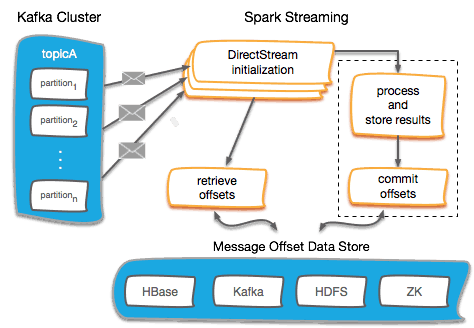

In [9]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 03:46:39


In [11]:
sc = pyspark.SparkContext()
ssc = StreamingContext(sc,5)

kafka_topic_name = "reco-train"
kafka_bootstrap_servers = 'localhost:9092'

kvs = KafkaUtils.createStream(ssc, kafka_bootstrap_servers, 'spark-streaming-consumer', {kafka_topic_name:1}) 
kvs = KafkaUtils.createDirectStream(ssc, [kafka_topic_name], {"metadata.broker.list": kafka_bootstrap_servers})
kvs = KafkaUtils.createDirectStream(ssc, [kafka_topic_name], {
                        'bootstrap.servers':kafka_bootstrap_servers,
                        'group.id':'test-group',
                        'auto.offset.reset':'largest'})

lines = kvs.map(lambda x: x[1])
counts = lines.flatMap(lambda line: line.split(' '))
counts = lines.flatMap(lambda line: line.split(' ')).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a+b)
counts.pprint()
ssc.start()
# stream will run for 50 sec
ssc.awaitTerminationOrTimeout(50)
ssc.stop()
sc.stop()

-------------------------------------------
Time: 2021-06-25 03:46:50
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:46:55
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:00
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:05
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:10
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:15
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:20
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:25
-------------------------------------------

-------------------------------------------
Time: 2021-06-25 03:47:30
----------

## Further exploration
- https://towardsdatascience.com/enabling-streaming-data-with-spark-structured-streaming-and-kafka-93ce91e5b435
